In [4]:
using JuMP
using LinearAlgebra
using Statistics
using Plots
using GLMNet
using DelimitedFiles
using GMT
using DataFrames
using Lasso

#### The following function is a replication of the Spike and Slab model presented in Giannone et al. (2021), designed to study sparsity in predictive economics models.

In [5]:
function SpikeSlabGLP(y,x,u,abeta=1,bbeta=1,Abeta=1,Bbeta=1,M=1100,N=100)

#     if u==0
#         u = zeros(size(y)); l=0; 
#     else
#         l=size(u,2);
#     end
#     if isempty(abeta) || isempty(bbeta); abeta=1; bbeta=1; end
#     if isempty(Abeta) || isempty(Bbeta); Abeta=1; Bbeta=1; end
#     if isempty(M); M=110000; N=10000; end
#     if isempty(N) && ~isempty(M); N=round(M/11); end
    l=size(u,2);
    (T,k)=size(x)
    varx=var(x[:,1],dims=1)

  # edges of grids for q & R2
    edgesq=[0:.001:.1 ; .11:.01:.9 ; .901:.001:1]'
    edgesR2=[0:.001:.1 ; .11:.01:.9 ; .901:.001:1]'

    # storage & preliminary calculations
    if l>0; store_phi=zeros(l,M); end
    store_B=zeros(k,M)
    store_s2=zeros(M,1)
    store_gam=zeros(M,1)
    store_z=zeros(k,M)
    store_q=zeros(M,1)
    store_R2=zeros(M,1)
    store_aux = zeros(M,1)
    
    areaq=(edgesq[2:end]-edgesq[1:end-1])'
    areaR2=(edgesR2[2:end]-edgesR2[1:end-1])'
    areaqR2=repeat(areaq,length(areaR2),1).*repeat(areaR2',1,length(areaq)); # areaq.*areaR2"
    intq=edgesq[1:end-1]'+areaq/2
    intR2=edgesR2[1:end-1]'+areaR2/2
    INTQ=repeat(intq,length(intR2),1)
    INTR2=repeat(intR2',1,length(intq))
    
    
    xx=x'*x; xy=x'*y; yx=y'*x; yy=y'*y
    xx=x'*x; xy=x'*y; yx=y'*x; yy=y'*y
    if l>0; xu=x'*u; yu=y'*u; uu=u'*u; invuu=uu\I(l); cholinvuu=factorize(invuu); ux=u'*x; invuuuy=invuu*u'*y; invuuux=invuu*u'*x
    elseif l==0; xu=zeros(k,1); yu=zeros(1,1); uu=zeros(1,1); ux=zeros(1,k); phi=0; end
    
    QR2=INTQ.*(1 .- INTR2)./INTR2
    prodINT = zeros(size(INTQ,1),size(INTQ,1),k+1)
    for ttt=0:k
        prodINT[:,:,ttt+1]=INTQ.^(ttt+ttt/2+abeta-1).*(1 .- INTQ).^(k-ttt+bbeta-1).*INTR2.^(Abeta-1-ttt/2).*(1 .- INTR2).^(ttt/2+Bbeta-1).*areaqR2
        end
    
    # starting values [based on Lasso under the assumption that the x's explain 50# of var(resy)]
    if l>0; phi0=invuuuy; resy=y-u.*phi0; store_phi[:,1]=phi0; else; resy=y; end
    
    λ = sqrt.(8*k*varx.*var(resy,dims=1)/2)/(2*length(resy))
     path = glmnet(x,resy, lambda= λ, standardize=false)
    store_B[:,1]=path.betas
    b=path.betas

#     b0= fit(LassoPath,x, resy, λ = λ, standardize=false)
#     b_temp=coef(b0)[2:end]
#     b = Matrix(b_temp')'

    store_B[:,1]= b;
    s2=sum((resy-x*b).^2)/T; store_s2[1]=s2
    z= b .!=0; store_z[:,1]=z
    tau=sum(z)
    

    start = time()
    for i=2:M
        counter=i
        if i==100*floor(.01*i)
            println(i)
        end
    
    # draw q & R2
        pr_qR2=exp.(-(.5*k*varx*b'*b/s2).*QR2).*dropdims(prodINT[:,:,tau+1], dims = (findall(size(prodINT[:,:,tau+1]) .== 1)...,));    
        cdf_qR2=cumsum(pr_qR2[:]/sum(pr_qR2[:]))
        aux=sum(cdf_qR2 .< rand(1))+1
        
        q=INTQ[aux]
        store_q[i]=q
        R2=INTR2[aux]
        store_R2[i]=R2
        gam=sqrt.((1/(k*varx*q))*R2/(1-R2))
        store_gam[i]=gam[1]
        
        store_aux[i]= aux
    # draw phi
        if l>0
            phihat=invuuuy-invuuux*store_B[:,i-1]
            Vphi=invuu*s2
            phi=(randn(1,l)*sqrt(s2)*cholinvuu)'+phihat
            store_phi[:,i]=phi'
        end
    
    # draw z
        for j=1:k
            z0=copy(z); z0[j]=0
            z1=copy(z); z1[j]=1
            tau0=sum(z0)
            tau1=sum(z1)
            dimz0 = Int(sqrt(size(xx[z0*z0'.==1],1)))
            dimz1 = Int(sqrt(size(xx[z1*z1'.==1],1)))
            W0=reshape(xx[z0*z0'.==1],dimz0,dimz0)+I(tau0)./gam^2
            W1=reshape(xx[z1*z1'.==1],dimz1,dimz1)+I(tau1)./gam^2
            bhat0=W0\(xy[z0 .== 1,1]-xu[z0 .== 1,1].*phi)
            bhat1=W1\(xy[z1 .== 1,1]-xu[z1 .== 1,1]*phi)

            # note: 2*sum(log(diag(chol(W0)))) improves speed & accuracy of log(det(W0))
        if size(W0,1)==1; DcholW0 = [factorize(W0)]; else; DcholW0 = Diagonal(factorize(W0).U); end
            if size(W1,1)==1; DcholW1 = [factorize(W1)]; else; DcholW1 = Diagonal(factorize(W1).U); end
            log_pr_z0=tau0*log(q)+(k-tau0)*log(1-q)-tau0*log(gam[1])-.5*2*sum(log(DcholW0))-.5*T*log(yy-(2*yu*phi)[1]+(phi'*uu*phi)[1]-(yx[z0' .== 1]'*bhat0)[1]+(phi'*ux[z0' .==1]'*bhat0)[1])
            log_pr_z1=tau1*log(q)+(k-tau1)*log(1-q)-tau1*log(gam[1])-.5*2*sum(log(DcholW1))-.5*T*log(yy-(2*yu*phi)[1]+(phi'*uu*phi)[1]-(yx[z1' .== 1]'*bhat1)[1]+(phi'*ux[z1' .==1]'*bhat1)[1])
            z[j]= Int(rand(1)[1]<=(1/(exp(log_pr_z0-log_pr_z1)+1)))
        end
        
        dimz = Int(sqrt(size(xx[z*z'.==1],1)))
        tau=sum(z);    
        W=reshape(xx[z*z'.==1],dimz,dimz)+I(tau)./gam^2
        bhat=W\(xy[z .== 1,1]-xu[z .== 1,1].*phi)
        store_z[:,i]=z
    
        # draw s2
        niu = yy-(2*yu*phi)[1]+(phi'*uu*phi)[1]-(bhat'*W*bhat)[1]
        s2= 1 ./rand(Gamma(T/2,2/niu))
        store_s2[i]=s2
    
        # draw b
        b=(randn(1,tau)*factorize(s2*I(tau)/W).U)'+bhat
        B_temp = zeros(k,1)
        B_temp[z.==1,1] = b
        store_B[:,i]= B_temp;
    end
    timeGibbs= time() - start


    #histogram(store_q)
    
    
    
    return store_B, store_z,store_phi,store_q,store_R2,store_gam,store_s2,y,x,u,T,k

        
end
    

SpikeSlabGLP (generic function with 7 methods)

#### Testing the model with simulated data.

In [6]:
Nobs= 1000
Y = randn(Nobs)
x1= [0.7*Y Y.^2  exp.(Y) Y.^3  Y.^4 Y.^5 Y.^5 0.1*Y ]
x2 = randn(Nobs,8)/5
x3 = randn(Nobs,20)
U = ones(Nobs)
X = [x1+x2 x3];
M=1100;
N=100;
abeta=1; Abeta=1; bbeta=1; Bbeta=1;

store_B,store_z,store_phi,store_q,store_R2,store_gam,store_s2,y,x,u,T,k =SpikeSlabGLP(Y,X,U);

100
200
300
400
500
600
700
800
900
1000
1100


#### Following figure resembles Figure 4.3 of the paper, showing the posterior probability of inclusion (being non-zero) in the model under $\beta(1,1)$ prior.

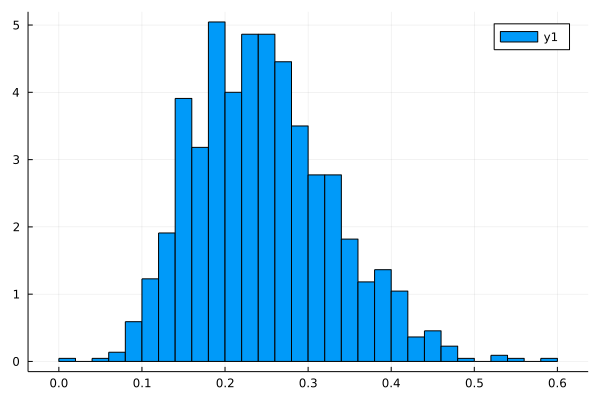

In [7]:
Plots.histogram(store_q, normalize=true)

#### The next figure, resembling Figure 4.4, shows the fraction of times each variable was incuded in the model.

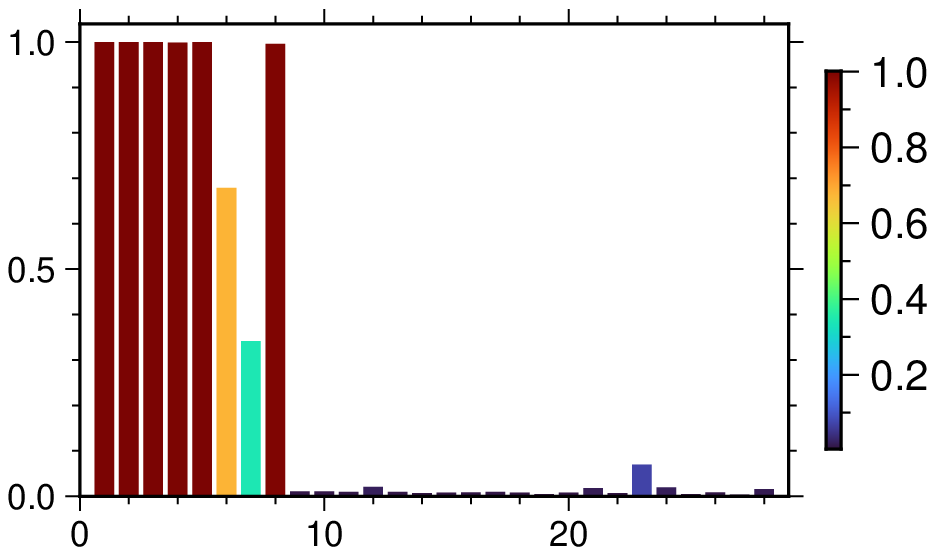

In [26]:
meanZ=mean(store_z[:,N+1:M]', dims=1)
GMT.bar(vec(meanZ), figsize=(6,4), colorbar=true, show=true)

#### Bringing data used in the paper to the model

In [57]:
# Import Macro 1 data
data_mac1 = readdlm(raw"D:\PhD\Second Year\Comp Econ\Project\Sparsity\mac1.csv", ',' )

y_mac1= data_mac1[:,end];
u_mac1=vec(ones(size(data_mac1,1),1))
x_mac1=data_mac1[:,1:end-1];


In [65]:
store_B,store_z,store_phi,store_q,store_R2,store_gam,store_s2,y,x,u,T,k =SpikeSlabGLP(y_mac1,x_mac1,u_mac1)
q_mac1 = store_q; 

100
200
300
400
500
600
700
800
900
1000
1100


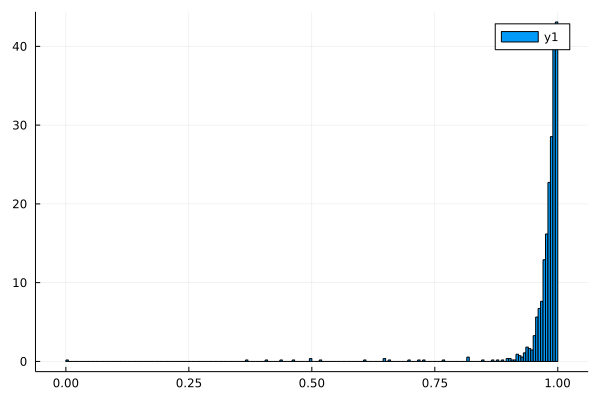

In [66]:
Plots.histogram(q_mac1, normalize=true)

In [67]:
# Import Macro 2 data
data = readdlm(raw"D:\PhD\Second Year\Comp Econ\Project\Sparsity\mac2.csv", ',' )
u_mac2 = data[:,1];
x_mac2 = data[:,2:end-1];
y_mac2 =data[:,end]; 

In [68]:
store_B,store_z,store_phi,store_q,store_R2,store_gam,store_s2,y,x,u,T,k =SpikeSlabGLP(y_mac2,x_mac2,u_mac2)
q_mac2 = store_q; 

100
200
300
400
500
600
700
800
900
1000
1100


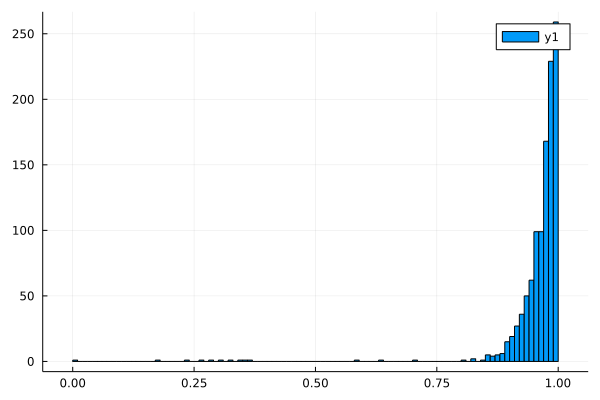

In [70]:
Plots.histogram(q_mac2)